## Import Libs

In [1]:
import os,sys
# install deepspeech - https://github.com/SeanNaren/deepspeech.pytorch
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
import sys
sys.path.append('/scratch/f006pq6/projects/deep-speech-reveal-hessian/src/deepspeech1')
import torch
import torch.nn as nn
import hydra

from t import DeepSpeech1,DeepSpeech1Model,CustomAudioDataset

from utils import *

from ctc_loss_imp import ctc_loss_imp, ctc_loss_imp_not_parallel
import matplotlib
%matplotlib inline



In [4]:
#data config
config = {
    'sampling_rate': 16000,
    'win_length_ms': 32,
    'step_length_ms': 20,
    'mfcc_bins': 26,
    'batch_size': 32
}

# Define the character-to-number mapping with space as 0 and ' as the last number
char_to_num = {
    ' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9,
    'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18,
    's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, "'": 27
}
num_to_char = {v: k for k, v in char_to_num.items()}

config['char_to_num'] = char_to_num
config['num_to_char'] = num_to_char

#network config
# Update the existing config dictionary with the specified values
config.update({
    'n_hidden_1': 2048,
    'n_hidden_2': 2048,
    'n_hidden_3': 2048,
    'n_hidden_5': 2048,
    'n_hidden_6': len(char_to_num)+1,
    'n_cell_dim': 2048,
    'dropout': [0.0] * 6,  # Assuming 6 dropout rates are needed
    'overlap': True,
    'layer_norm': False,
    'n_input': 26,
    'n_context': 9
})

# training config
config.update({
    'gpus': 4,
    'learning_rate':0.1,
    'cpus':16,
    'max_epoch': 100,
    'half_precision': False,  # Enable half precision

})


# %%
# Initialize your dataset and model
tsv_path = '/scratch/f006pq6/datasets/commonvoice_v2/train.tsv'
clips_dir = '/scratch/f006pq6/datasets/commonvoice_v2/clips'
dataset = CustomAudioDataset(tsv_path, clips_dir, config)

model = DeepSpeech1Model(config).to('cuda')

In [5]:
import librosa
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [6]:
device = 'cuda'
inputs, targets, input_length, target_length = dataset[4]
inputs = inputs.unsqueeze(0)
input_length = torch.tensor([input_length])
target_length = torch.tensor([target_length])

inputs = inputs.to(device)
targets = targets.to(device)


# # ==============================================================================
# # Make the input a bit smaller

print('input shape:',inputs.shape)


input shape: torch.Size([1, 139, 26])


In [7]:
target_length

tensor([32])

In [38]:
# ------------------------------------------------------------------------------
#  Loss function, get target dL/dW
# ------------------------------------------------------------------------------
##get the param to match gradient
weight_param = model.model.layer_6.weight
# weight_param = model_simple.fc2.weight
print('weight shape:', weight_param.shape)

out = model(inputs, input_length) # 1 176 29
out = out.transpose(0, 1)
out = out[:out.shape[0]//3*3]  # TxNxH
out = out.view(-1, 3, 1, out.shape[-1])
out = out.mean(dim=1)
out =  out.log_softmax(-1)
output_sizes = torch.tensor([out.shape[0]])

# make target same size of output size
targets = targets[-out.shape[1]:]
target_sizes = torch.tensor([0])
target_sizes[0]= len(targets)


print('model input shape, input_sizes:', inputs.shape, input_length)
print('model output shape, output_sizes, hidden sizes:', out.shape, output_sizes, 0)
print('target sizes, targets: ', target_sizes, targets)

# out = out.transpose(0, 1)  # TxNxH
# out =  out.log_softmax(-1)
# from torch.nn import CTCLoss
# loss_ = CTCLoss(blank=model_ds.labels.index('_'), reduction='sum', zero_infinity=True)(out, targets, output_sizes, target_sizes)
loss_func = lambda x,y : ctc_loss_imp(x, y, output_sizes, target_sizes)
# loss_func = lambda x,y :loss_func_lib (x, y, output_sizes, target_sizes)


loss_func_lib   = torch.nn.CTCLoss()
loss = loss_func(out, targets)
loss_lib = loss_func_lib(out, targets, output_sizes, target_sizes)
print('loss:', loss.item())
print('loss by pt lib:', loss_lib.item())
# grab gradient to match
dldw_target= torch.autograd.grad(loss, weight_param)[0]

print('grad shape:',dldw_target.shape, 'grad_norm', dldw_target.norm())


weight shape: torch.Size([29, 2048])
model input shape, input_sizes: torch.Size([1, 139, 26]) tensor([139])
model output shape, output_sizes, hidden sizes: torch.Size([46, 1, 29]) tensor([46]) 0
target sizes, targets:  tensor([1]) tensor([12], device='cuda:0')
loss: 147.40452495313735
loss by pt lib: 147.40452575683594
grad shape: torch.Size([29, 2048]) grad_norm tensor(201.0341, device='cuda:0')


In [39]:
# ------------------------------------------------------------------------------
# Meta loss
# ------------------------------------------------------------------------------
def meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param):
    loss = loss_func(output, targets)
    dldw = torch.autograd.grad(loss, weight_param, create_graph=True)[0]
    loss = ((dldw-dldw_target)**2).sum() #MSE
    #loss = 1 - torch.nn.functional.cosine_similarity(dldw.reshape(1,-1), dldw_target.reshape(1,-1))

    return loss,dldw

# ------------------------------------------------------------------------------
# Init random input
# ------------------------------------------------------------------------------

x_hat = torch.nn.Parameter(torch.rand_like(inputs).to(device),requires_grad=True)

out = model(x_hat, input_length) # 1 176 29
#out = model_ds(x_hat,input_sizes)
out = out.transpose(0, 1)  # TxNxH
out =  out.log_softmax(-1) 

loss,dldw = meta_loss(out, targets, None, None, dldw_target,  weight_param)
print('loss, dldw norm:', loss.item(), torch.norm(dldw))

loss, dldw norm: 37958.08203125 tensor(15.4771, device='cuda:0', grad_fn=<NormBackward1>)


In [42]:
# ------------------------------------------------------------------------------
# Train
# ------------------------------------------------------------------------------
import torch.optim as optim

optimizer = optim.Adam([x_hat], lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=.5,patience=1000)

i=0
loss_history = []
while True:

    out = model(x_hat, input_length) # 1 176 29
    out = out.transpose(0, 1)
    out = out[:out.shape[0]//3*3]  # TxNxH
    out = out.view(-1, 3, 1, out.shape[-1])
    out = out.mean(dim=1)
    out =  out.log_softmax(-1)
    # mloss, dldw_f = meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param)
    mloss, dldw_f = meta_loss(out, targets, None, None, dldw_target,  weight_param)


    optimizer.zero_grad()
    mloss.backward()
    grad = x_hat.grad.data

    optimizer.step()

    loss_history.append(mloss.item())

    if i % 10 == 0:
        print('Iteration, Loss, Gradient Norm, Learning Rate: {:4d}, {:.4f}, {:.4f}, {:.4f}'.format(i, mloss.item(), grad.norm().item(), optimizer.param_groups[0]["lr"]))
        scheduler.step(mloss.item())

    if (i+ 1) % 10000 == 0:
        torch.save({
            'model':model.state_dict(),
            'loss_history': loss_history,
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
             }, f'model_checkpoint_{i+ 1}.pt')
        print(f'Model saved at iteration {i+ 1}')


    i+=1

Iteration, Loss, Gradient Norm, Learning Rate:    0, 37166.1250, 36.1523, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   10, 35037.7969, 41.4757, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   20, 32766.6387, 41.5758, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   30, 30571.9648, 39.7377, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   40, 28554.5449, 37.1172, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   50, 26770.2500, 33.8141, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   60, 25241.4160, 30.3755, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   70, 23957.9141, 27.2197, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   80, 22877.5430, 24.6717, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   90, 21952.5977, 22.6502, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  100, 21148.6953, 21.0147, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  110, 20435.2539, 19.6687, 0.1000


KeyboardInterrupt: 

## Plot sth

In [32]:
%matplotlib inline

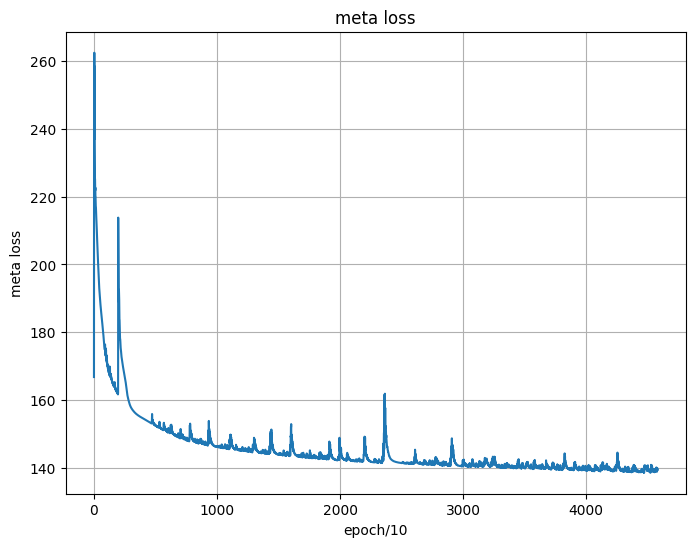

In [33]:
plot_loss_over_epoch(loss_history, 'meta loss','epoch/10','meta loss')

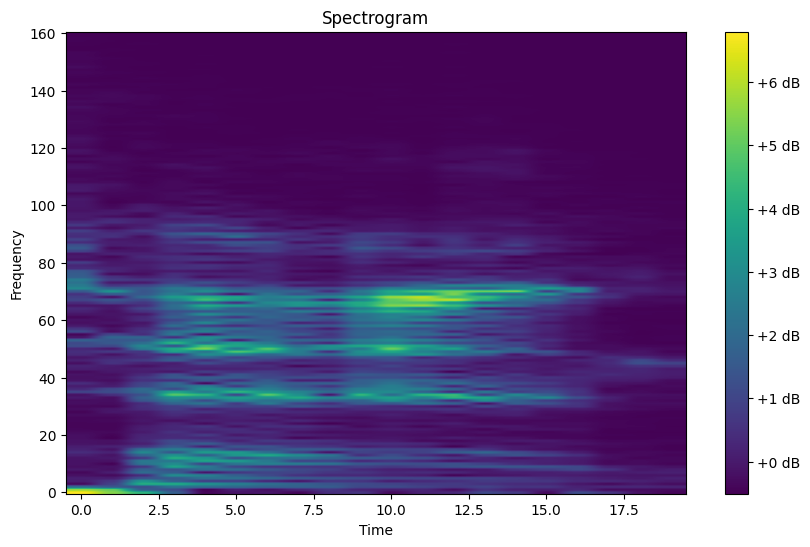

In [34]:
plot_spectrogram(inputs.detach())

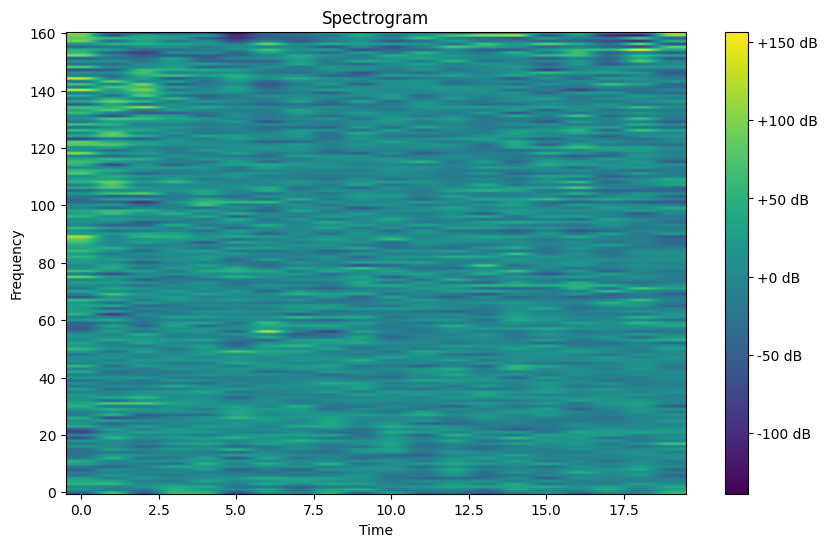

In [35]:
plot_spectrogram(x_hat.detach())

In [12]:
#pytorch 2nd order derivative test 
f = lambda x: x**3 + 2*x**2 - 3*x + 1
x = torch.tensor(1.0, requires_grad=True)

z = f(x)
y = z


dydx = torch.autograd.grad(y, x, create_graph=True)
d2ydx = torch.autograd.grad(dydx, x) # 10
print(dydx, d2ydx)

(tensor(4., grad_fn=<AddBackward0>),) (tensor(10.),)


In [43]:
plot_spectrogram(torch.abs(inputs.detach() - x_hat.detach()))

RuntimeError: The size of tensor a (25) must match the size of tensor b (20) at non-singleton dimension 3